### Package Declarations

In [1]:
# classical
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

# quantum
from qiskit.quantum_info import SparsePauliOp, StabilizerState, Clifford, Statevector, Pauli, random_clifford
from qiskit_algorithms import VQE
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.gradients import ReverseEstimatorGradient

### Function Declarations

In [2]:
# returns a random non-trivial Pauli-string of the form 'IZXYZX' of length N
def RandomPauliString(N):
    pauli_chars = ['I', 'X', 'Y', 'Z']
    Pauli_string = ''.join(random.choice(pauli_chars) for _ in range(N))
    if Pauli_string == N * 'I':
        return RandomPauliString(N)
    return Pauli_string

# Evaluate gradients
def compute_gradient(circuit, params, observable):

    estimator = Estimator()
    gradient = ReverseEstimatorGradient(estimator)
    
    # Bind parameters and compute gradients
    job = gradient.run([circuit], [observable], [params])
    result = job.result()
    return result.gradients[0]

### Implementing PQC-ansätze

def create_mHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['ry', 'rz'], entanglement='circular', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

def create_fHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

# returns a random PQC with N qubits and certain depth
def randomPQC(N, depth):

    circuit = QuantumCircuit(N)
    params = ParameterVector("theta", length=N * depth)
    param_index = 0
    
    for layer in range(depth):
        # apply random single-qubit rotations
        for qubit in range(N):
            gate_type = random.choice(["rx", "ry", "rz"])  # Choose random rotation gate
            getattr(circuit, gate_type)(params[param_index], qubit)
            param_index += 1
        
        # apply random Clifford gates
        for qubit in range(N):
            if random.random() < 0.5:  # apply Hadamard gate with 50% probability
                circuit.h(qubit)
            if random.random() < 0.5:  # apply S gate with 50% probability
                circuit.s(qubit)
        
        # apply more CX gates
        for _ in range(N):  # increase CX gates to approximately N per layer
            q1, q2 = random.sample(range(N), 2)  # pick two random qubits
            circuit.cx(q1, q2)
    
    return circuit

### LCE subroutines

# takes a parameterized quantum circuit and splits it into two subcircuits at the k-th rotation gate
def split_circuit(circuit, k):
    parameters = list(circuit.parameters) # extract the parameters in the order they appear
    target_param = parameters[k]  # The theta[k] parameter

    # initialize left and right subcircuits
    left_circuit = QuantumCircuit(circuit.num_qubits)
    right_circuit = QuantumCircuit(circuit.num_qubits)

    # iterate over the circuit instructions and distribute them accordingly
    param_found = False  # flag to track when we find the target parameter

    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        # check if the instruction has a parameter that matches target_param
        instr_params = instr.params  # parameters of the current gate
        
        if any(isinstance(p, ParameterVector) for p in instr_params):
            continue  # skip parameter vectors (if any)

        # if this instruction has the target parameter
        if target_param in instr_params:
            param_found = True  # we have reached the split point
            continue  # skip adding this gate (since it belongs to theta[k])

        # add the gate to the appropriate subcircuit
        if not param_found:
            left_circuit.append(instr, qargs, cargs)
        else:
            right_circuit.append(instr, qargs, cargs)

    return left_circuit, right_circuit

# takes a PQC and removes all rotation gates (i.e. returns U(0) without including rotation gates)
def remove_zero_rotations(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)  # create empty circuit
    
    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if instr.name in ['rx', 'ry', 'rz']:  # check if it is a rotation gate
            param_value = instr.params[0]  # extract parameter value
            
            # remove gate if rotation is exactly zero
            if isinstance(param_value, (int, float)) and np.isclose(param_value, 0):
                continue  # skip adding this gate

        # otherwise, add the instruction
        new_circuit.append(instr, qargs, cargs)

    return new_circuit

# take a PQC and returns the rotation axis 'X', 'Y', or 'Z' of the k-th rotation gate, and the qubit index on which the rotation is acting on
def get_rotation_axis(circuit, k):
    param_count = 0  # track parameter index
    
    for instruction in circuit.data:
        gate = instruction.operation
        qargs = instruction.qubits
        if gate.name in ["rx", "ry", "rz"]:  # check if it is a rotation gate
            num_params = len(gate.params)
            if num_params > 0:
                if param_count == k:
                    qubit_index = circuit.qubits.index(qargs[0])
                    return gate.name[-1].upper(), qubit_index  # extract X, Y, or Z
                param_count += 1

# constructs the Q_tilde circuit which induces a relative phase between the shifted evolved Pauli strings
def phase_inducer(circuit, k, pauli_string):
    N = circuit.num_qubits
    Q_tilde = QuantumCircuit(N)
    W = QuantumCircuit(N)
    V, j = get_rotation_axis(circuit, k)
    #pauli_string = pauli_string.replace('-','')
    _, W_a = split_circuit(circuit, k)
    W_a = remove_zero_rotations(W_a.assign_parameters(np.zeros(W_a.num_parameters)))

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    if pauli_string[j] != 'I':
        if V != pauli_string[j]:
            return W_a.inverse()
        
        if V == pauli_string[j]:
            if V == 'X' or V == 'Z':
                W.h(j)
            if V == 'Y':
                W.s(j)
            return W_a.inverse().compose(W)
        
    if pauli_string[j] == 'I':
        W_1 = QuantumCircuit(N)
        for idx in range(N):
            if pauli_string[idx] != 'I':
                i = idx
                break
        if pauli_string[i] == 'X' or pauli_string[i] == 'Y':
            W_1.cx(i, j)
        if pauli_string[i] == 'Z':
            W_1.cx(j, i)
        
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
        P_W = Pauli(pauli_string).evolve(Clifford(W_1))
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention

        if V != str(P_W[j]):
            return W_a.inverse().compose(W_1)

        if V == str(P_W[j]):
            W_2 = QuantumCircuit(N)
            if V == 'X' or V == 'Z':
                W_2.h(j)
            if V == 'Y':
                W_2.s(j)
            return W_a.inverse().compose(W_2.compose(W_1))

# constructs the Q circuit which diagonalizes the shifted evolved Pauli strings
def diagonalizer(circuit, pauli_string):
    N = circuit.num_qubits
    Q = QuantumCircuit(N)
    pauli_string = pauli_string.replace('-','')

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    for j in range(N):
        if pauli_string[j] == 'X':
            Q.h(j)
        if pauli_string[j] == 'Y':
            Q.h(j)
            Q.s(j)

    return Q

# takes the PQC, the input Pauli-string and the desired components k\in[D], and returns the Clifford-modified PQC with scalable gradients
def LinearCliffordEncoder(circuit, pauli_string, k):
    D = circuit.num_parameters
    Q_tilde = phase_inducer(circuit, k, pauli_string)
    circuit.barrier()
    U = circuit.compose(Q_tilde)

    P_tilde_0_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))))
    P_tilde_ek_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###
    #print("phased Pauli shifts:", P_tilde_0_ek, P_tilde_ek_ek) ###

    Q = diagonalizer(U, P_tilde_0_ek)
    Q.barrier()
    U = Q.compose(U)

    #print("diagonalized Pauli shifts:", Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))), ###
      #Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###

    return U

### Gradient Norm Benchmarking on near-Clifford Landscape Patches for Linear Depth PQCs

In [3]:
### EXPERIMENT I: Escaping Barren-Plateaus (Linear Depth mHEA-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for seed in range(number_of_runs):
        L = N # number of ansatz layers
        circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use fHEA here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1 = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1.pkl", "wb") as f:
    pickle.dump(data_trainability_1, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\desuvo18\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit_algorithms\gradients\base\base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


In [4]:
### EXPERIMENT Ia: Escaping Barren-Plateaus (Linear Depth fHEA-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for _ in range(number_of_runs):
        L = N # number of ansatz layers
        circuit_noLCE = EfficientSU2(N, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=L, flatten=True) # we use mHEA here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1a = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1a.pkl", "wb") as f:
    pickle.dump(data_trainability_1a, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [19]:
### EXPERIMENT Ib: Escaping Barren-Plateaus (Linear Depth rPQC-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for _ in range(number_of_runs):
        L = N # number of ansatz layers
        circuit_noLCE = randomPQC(N, 2*L) # we use rPQC here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1b = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1b.pkl", "wb") as f:
    pickle.dump(data_trainability_1b, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


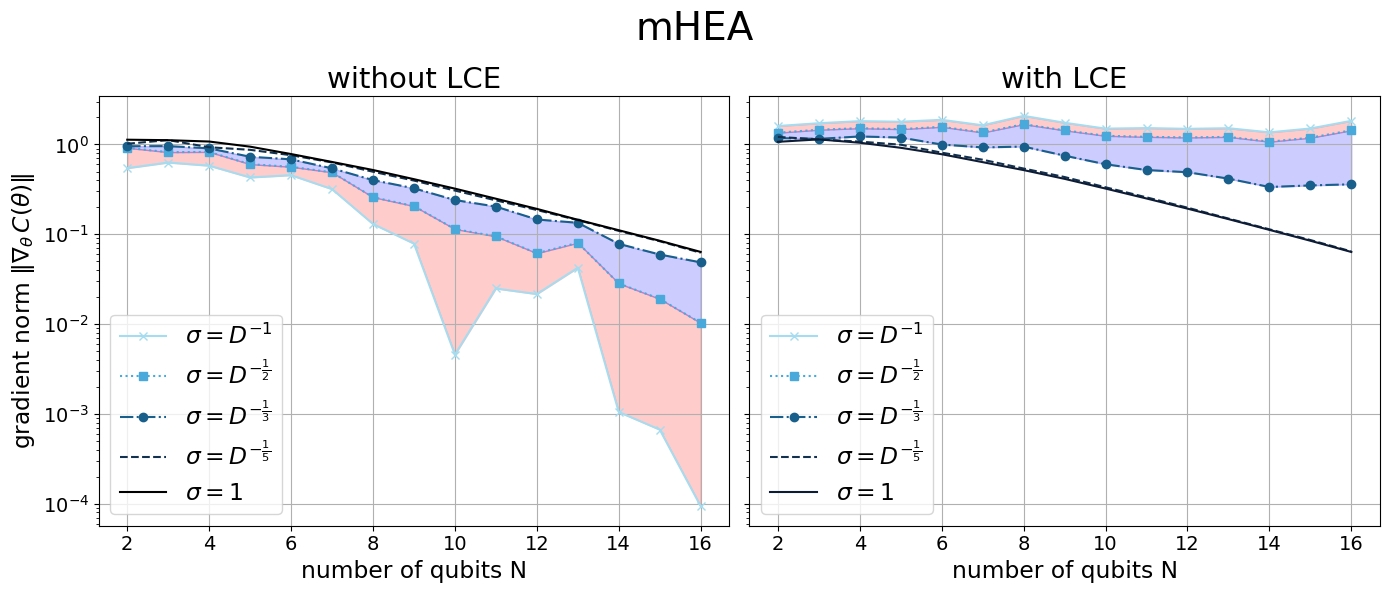

In [4]:
### Plotting the Results of EXPERIMENT I

# load data from file
with open("data_trainability_1.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("mHEA", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-mHEA.pdf", format="pdf")
plt.show()


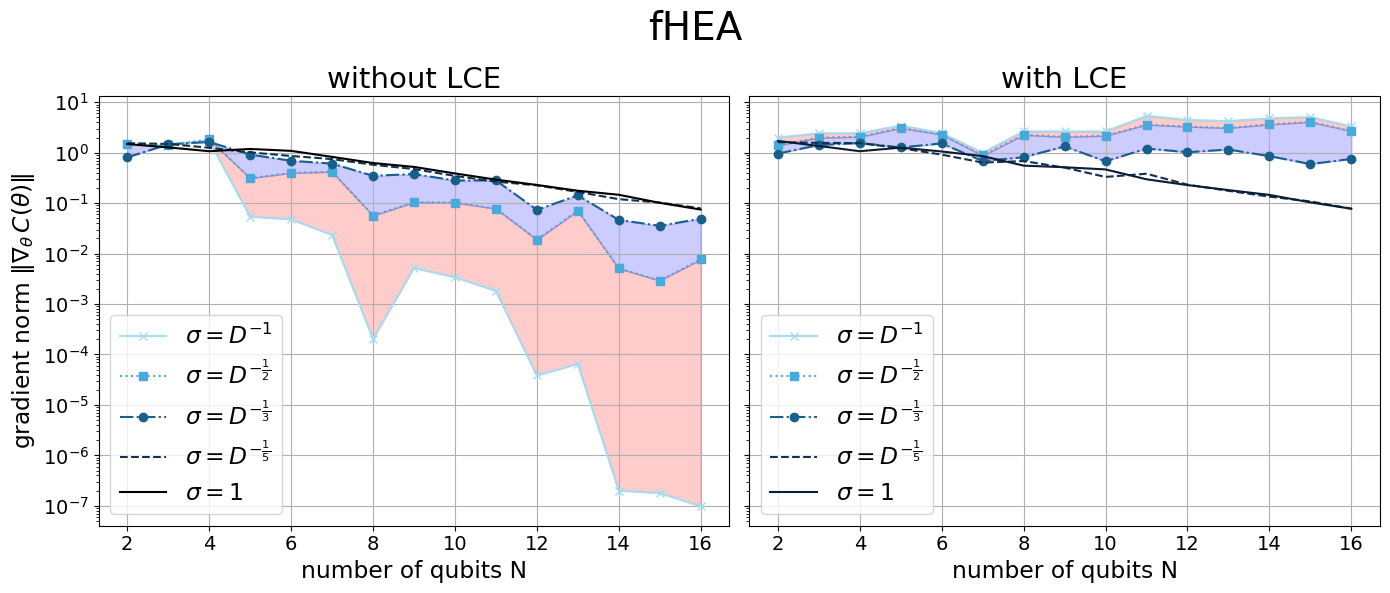

In [5]:
### Plotting the Results of EXPERIMENT Ia

# load data from file
with open("data_trainability_1a.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("fHEA", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-fHEA.pdf", format="pdf")
plt.show()

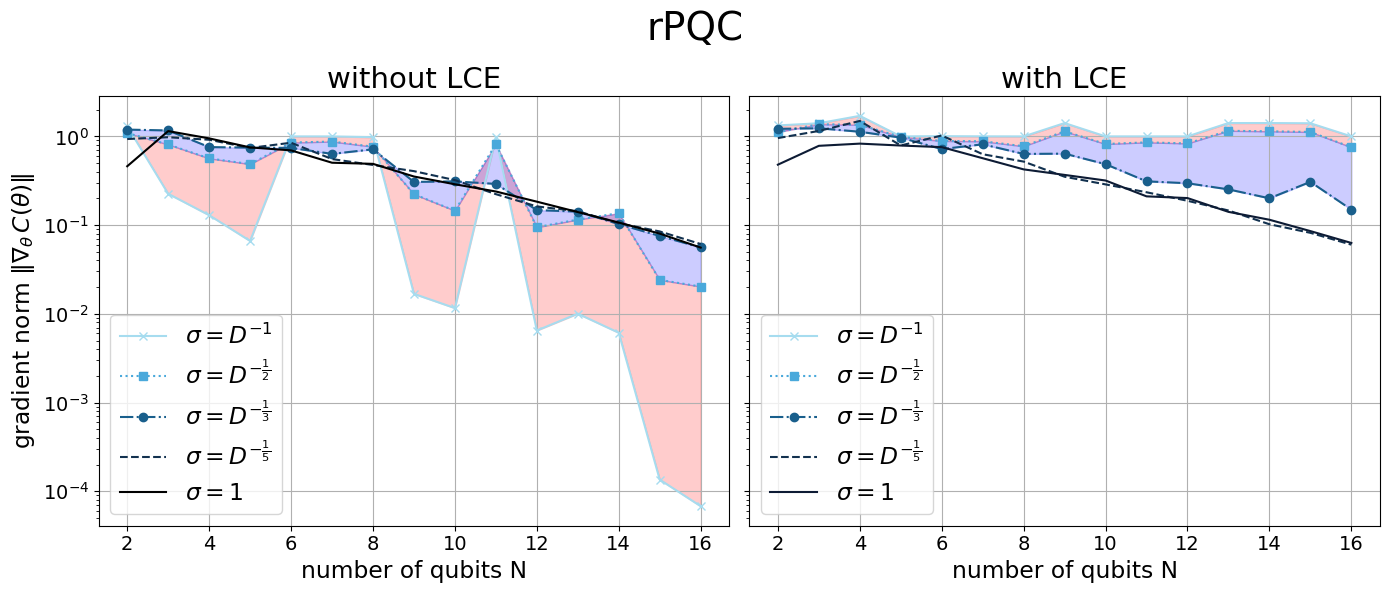

In [6]:
### Plotting the Results of EXPERIMENT Ib

# load data from file
with open("data_trainability_1b.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("rPQC", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-rPQC.pdf", format="pdf")
plt.show()

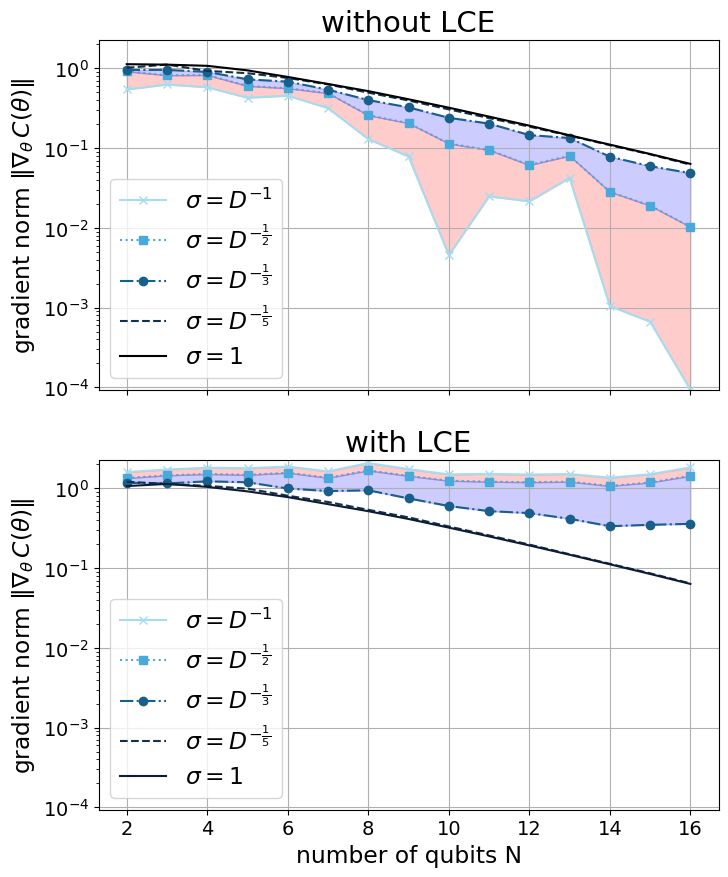

In [3]:
# Plotting the Results of EXPERIMENT I (vertically aligned panels)

# load data from file
with open("data_trainability_1.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Create vertically aligned subplots
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 10),
    sharex=True,
    #gridspec_kw={'height_ratios': [1.5, 1]}  # Top panel taller than bottom
)


font_size = 14

colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# First plot (without LCE)
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.set_yscale('log')
ax.legend(fontsize=font_size * 1.2, loc='lower left')

# Second plot (with LCE)
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.set_yscale('log')
ax.legend(fontsize=font_size * 1.2, loc='lower left')

# Determine unified y-limits across both subplots
y_min = min(np.min(means_theta1_noLCE), np.min(means_theta2_noLCE), np.min(means_theta3_noLCE),
            np.min(means_theta4_noLCE), np.min(means_theta5_noLCE),
            np.min(means_theta1), np.min(means_theta2), np.min(means_theta3),
            np.min(means_theta4), np.min(means_theta5))

y_max = max(np.max(means_theta1_noLCE), np.max(means_theta2_noLCE), np.max(means_theta3_noLCE),
            np.max(means_theta4_noLCE), np.max(means_theta5_noLCE),
            np.max(means_theta1), np.max(means_theta2), np.max(means_theta3),
            np.max(means_theta4), np.max(means_theta5)) * 1.1  # add some headroom

# Apply the same y-limits to both axes
for ax in axes:
    ax.set_ylim(y_min, y_max)

#axes[1].set_ylim([0.2*1e-2, 3])

# Unified layout
#plt.suptitle("mHEA", fontsize=font_size * 2)
plt.savefig("escapeBP.pdf", format="pdf")
plt.show()


### Gradient Norm Benchmarking on near-Clifford Landscape Patches for Shallow PQCs

In [10]:
### EXPERIMENT I_shallow: Escaping Barren-Plateaus (Shallow mHEA-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for seed in range(number_of_runs):
        L = 1 # number of ansatz layers
        circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use fHEA here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1 = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1_shallow.pkl", "wb") as f:
    pickle.dump(data_trainability_1, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [11]:
### EXPERIMENT Ia_shallow: Escaping Barren-Plateaus (Shallow fHEA-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for _ in range(number_of_runs):
        L = 1 # number of ansatz layers
        circuit_noLCE = EfficientSU2(N, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=L, flatten=True) # we use mHEA here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1a = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1a_shallow.pkl", "wb") as f:
    pickle.dump(data_trainability_1a, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [12]:
### EXPERIMENT Ib_shallow: Escaping Barren-Plateaus (Shallow rPQC-circuits)

N_max = 16 # maximal number of qubits

number_of_runs = 50 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_theta1_data = []
gradient_norms_theta2_data = []
gradient_norms_theta3_data = []
gradient_norms_theta4_data = []
gradient_norms_theta5_data = []

gradient_norms_theta1_data_noLCE = []
gradient_norms_theta2_data_noLCE = []
gradient_norms_theta3_data_noLCE = []
gradient_norms_theta4_data_noLCE = []
gradient_norms_theta5_data_noLCE = []

for N in N_values:

    gradient_norms_theta1_runs = []
    gradient_norms_theta2_runs = []
    gradient_norms_theta3_runs = []
    gradient_norms_theta4_runs = []
    gradient_norms_theta5_runs = []

    gradient_norms_theta1_runs_noLCE = []
    gradient_norms_theta2_runs_noLCE = []
    gradient_norms_theta3_runs_noLCE = []
    gradient_norms_theta4_runs_noLCE = []
    gradient_norms_theta5_runs_noLCE = []

    for _ in range(number_of_runs):
        L = 1 # number of ansatz layers
        circuit_noLCE = randomPQC(N, 5) # we use rPQC here
        D = circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        observable = SparsePauliOp.from_list([(pauli_string, 1.0)])

        circuit = LinearCliffordEncoder(circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta1 = np.random.normal(0, D**(-1), D)
        theta2 = np.random.normal(0, D**(-1/2), D)
        theta3 = np.random.normal(0, D**(-1/3), D)
        theta4 = np.random.normal(0, D**(-1/5), D)
        theta5 = np.random.normal(0, 1, D)

        gradient_theta1 = compute_gradient(circuit, theta1, observable)
        gradient_theta2 = compute_gradient(circuit, theta2, observable)
        gradient_theta3 = compute_gradient(circuit, theta3, observable)
        gradient_theta4 = compute_gradient(circuit, theta4, observable)
        gradient_theta5 = compute_gradient(circuit, theta5, observable)

        gradient_norms_theta1_runs.append(np.linalg.norm(gradient_theta1))
        gradient_norms_theta2_runs.append(np.linalg.norm(gradient_theta2))
        gradient_norms_theta3_runs.append(np.linalg.norm(gradient_theta3))
        gradient_norms_theta4_runs.append(np.linalg.norm(gradient_theta4))
        gradient_norms_theta5_runs.append(np.linalg.norm(gradient_theta5))

        gradient_theta1_noLCE = compute_gradient(circuit_noLCE, theta1, observable)
        gradient_theta2_noLCE = compute_gradient(circuit_noLCE, theta2, observable)
        gradient_theta3_noLCE = compute_gradient(circuit_noLCE, theta3, observable)
        gradient_theta4_noLCE = compute_gradient(circuit_noLCE, theta4, observable)
        gradient_theta5_noLCE = compute_gradient(circuit_noLCE, theta5, observable)

        gradient_norms_theta1_runs_noLCE.append(np.linalg.norm(gradient_theta1_noLCE))
        gradient_norms_theta2_runs_noLCE.append(np.linalg.norm(gradient_theta2_noLCE))
        gradient_norms_theta3_runs_noLCE.append(np.linalg.norm(gradient_theta3_noLCE))
        gradient_norms_theta4_runs_noLCE.append(np.linalg.norm(gradient_theta4_noLCE))
        gradient_norms_theta5_runs_noLCE.append(np.linalg.norm(gradient_theta5_noLCE))
        
        
    gradient_norms_theta1_data.append(gradient_norms_theta1_runs)
    gradient_norms_theta2_data.append(gradient_norms_theta2_runs)
    gradient_norms_theta3_data.append(gradient_norms_theta3_runs)
    gradient_norms_theta4_data.append(gradient_norms_theta4_runs)
    gradient_norms_theta5_data.append(gradient_norms_theta5_runs)

    gradient_norms_theta1_data_noLCE.append(gradient_norms_theta1_runs_noLCE)
    gradient_norms_theta2_data_noLCE.append(gradient_norms_theta2_runs_noLCE)
    gradient_norms_theta3_data_noLCE.append(gradient_norms_theta3_runs_noLCE)
    gradient_norms_theta4_data_noLCE.append(gradient_norms_theta4_runs_noLCE)
    gradient_norms_theta5_data_noLCE.append(gradient_norms_theta5_runs_noLCE)
        
# store data in a dictionary
data_trainability_1b = {
    "N_values": N_values,
    "gradient_norms_theta1_data": gradient_norms_theta1_data,
    "gradient_norms_theta2_data": gradient_norms_theta2_data,
    "gradient_norms_theta3_data": gradient_norms_theta3_data,
    "gradient_norms_theta4_data": gradient_norms_theta4_data,
    "gradient_norms_theta5_data": gradient_norms_theta5_data,
    "gradient_norms_theta1_data_noLCE": gradient_norms_theta1_data_noLCE,
    "gradient_norms_theta2_data_noLCE": gradient_norms_theta2_data_noLCE,
    "gradient_norms_theta3_data_noLCE": gradient_norms_theta3_data_noLCE,
    "gradient_norms_theta4_data_noLCE": gradient_norms_theta4_data_noLCE,
    "gradient_norms_theta5_data_noLCE": gradient_norms_theta5_data_noLCE,
    
}

# save data in file
with open("data_trainability_1b_shallow.pkl", "wb") as f:
    pickle.dump(data_trainability_1b, f)

C:\Users\desuvo18\AppData\Local\Temp\ipykernel_2484\300868270.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


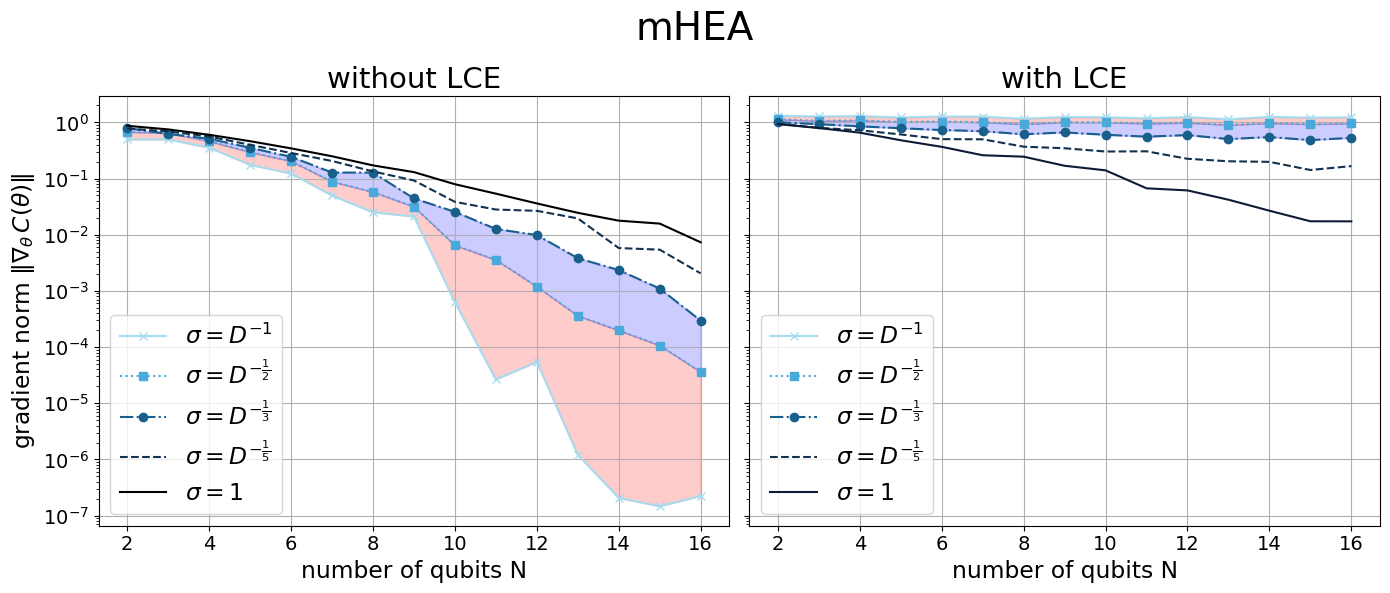

In [7]:
### Plotting the Results of EXPERIMENT I_shallow

# load data from file
with open("data_trainability_1_shallow.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("mHEA", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-mHEA-shallow.pdf", format="pdf")
plt.show()

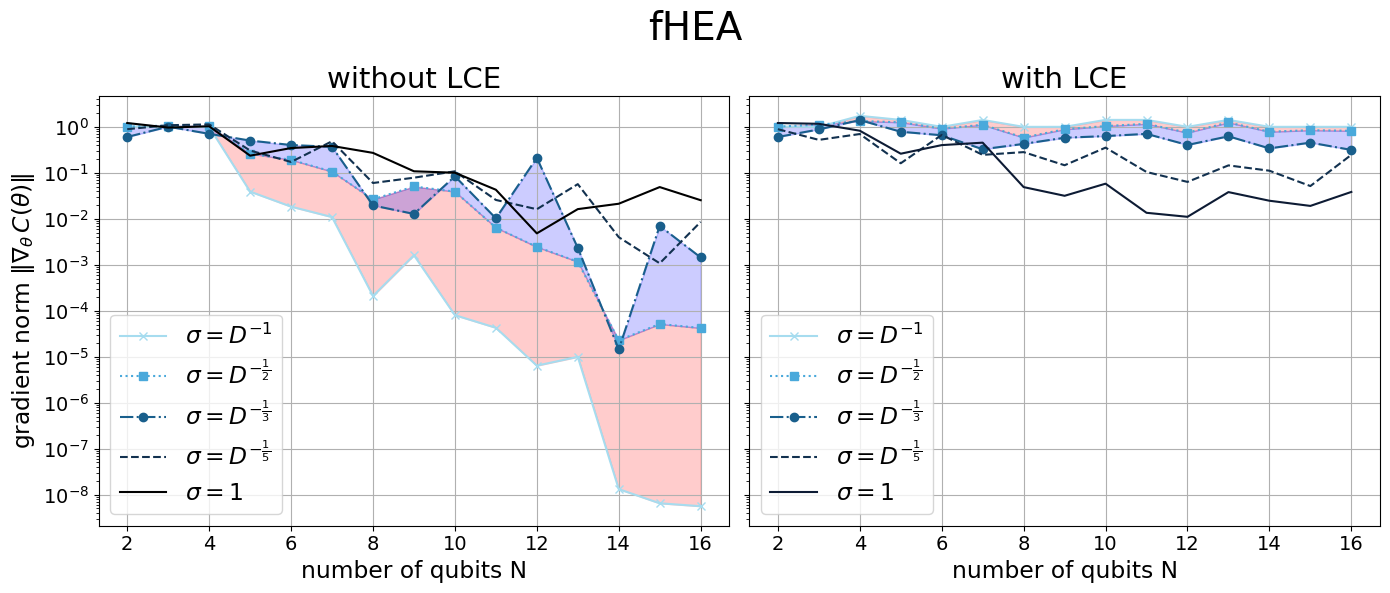

In [8]:
### Plotting the Results of EXPERIMENT Ia_shallow

# load data from file
with open("data_trainability_1a_shallow.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("fHEA", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-fHEA-shallow.pdf", format="pdf")
plt.show()

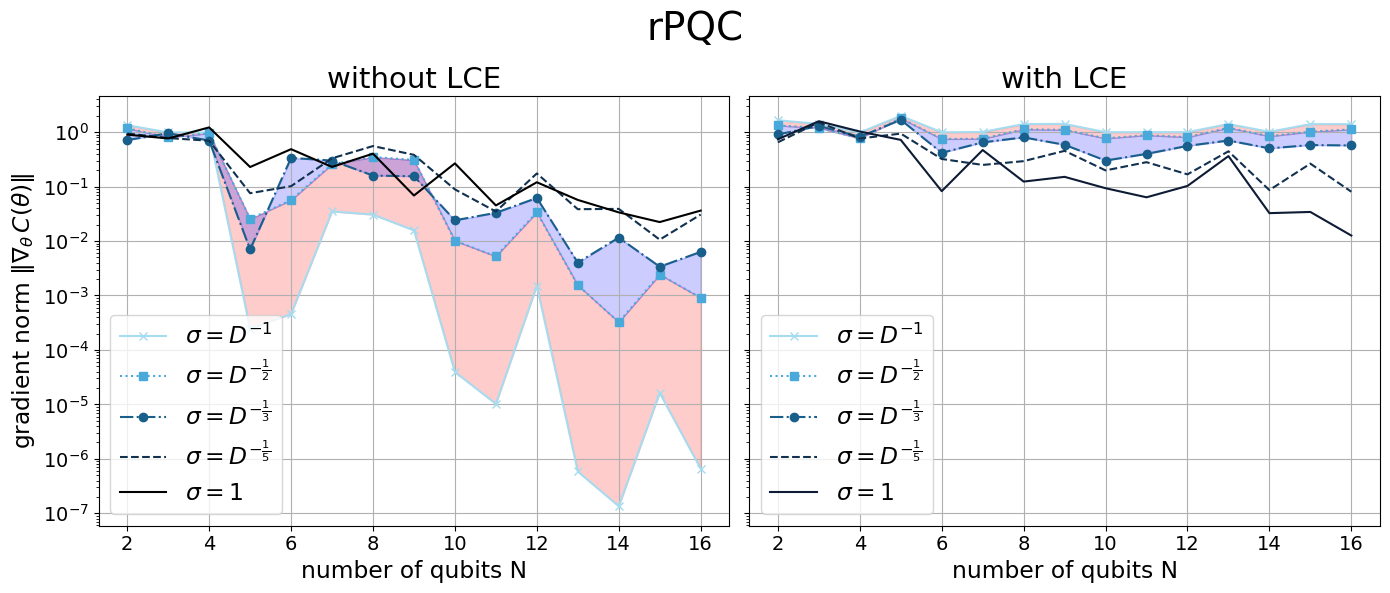

In [9]:
### Plotting the Results of EXPERIMENT Ib_shallow

# load data from file
with open("data_trainability_1b_shallow.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
gradient_norms_theta1_data = data["gradient_norms_theta1_data"]
gradient_norms_theta2_data = data["gradient_norms_theta2_data"]
gradient_norms_theta3_data = data["gradient_norms_theta3_data"]
gradient_norms_theta4_data = data["gradient_norms_theta4_data"]
gradient_norms_theta5_data = data["gradient_norms_theta5_data"]
gradient_norms_theta1_data_noLCE = data["gradient_norms_theta1_data_noLCE"]
gradient_norms_theta2_data_noLCE = data["gradient_norms_theta2_data_noLCE"]
gradient_norms_theta3_data_noLCE = data["gradient_norms_theta3_data_noLCE"]
gradient_norms_theta4_data_noLCE = data["gradient_norms_theta4_data_noLCE"]
gradient_norms_theta5_data_noLCE = data["gradient_norms_theta5_data_noLCE"]

# processing the data
gradient_norms_theta1_data = np.array(gradient_norms_theta1_data)
gradient_norms_theta2_data = np.array(gradient_norms_theta2_data)
gradient_norms_theta3_data = np.array(gradient_norms_theta3_data)
gradient_norms_theta4_data = np.array(gradient_norms_theta4_data)
gradient_norms_theta5_data = np.array(gradient_norms_theta5_data)
gradient_norms_theta1_data_noLCE = np.array(gradient_norms_theta1_data_noLCE)
gradient_norms_theta2_data_noLCE = np.array(gradient_norms_theta2_data_noLCE)
gradient_norms_theta3_data_noLCE = np.array(gradient_norms_theta3_data_noLCE)
gradient_norms_theta4_data_noLCE = np.array(gradient_norms_theta4_data_noLCE)
gradient_norms_theta5_data_noLCE = np.array(gradient_norms_theta5_data_noLCE)

means_theta1 = np.mean(gradient_norms_theta1_data, axis=1)
means_theta2 = np.mean(gradient_norms_theta2_data, axis=1)
means_theta3 = np.mean(gradient_norms_theta3_data, axis=1)
means_theta4 = np.mean(gradient_norms_theta4_data, axis=1)
means_theta5 = np.mean(gradient_norms_theta5_data, axis=1)
means_theta1_noLCE = np.mean(gradient_norms_theta1_data_noLCE, axis=1)
means_theta2_noLCE = np.mean(gradient_norms_theta2_data_noLCE, axis=1)
means_theta3_noLCE = np.mean(gradient_norms_theta3_data_noLCE, axis=1)
means_theta4_noLCE = np.mean(gradient_norms_theta4_data_noLCE, axis=1)
means_theta5_noLCE = np.mean(gradient_norms_theta5_data_noLCE, axis=1)

stds_theta1 = np.std(gradient_norms_theta1_data, axis=1)
stds_theta2 = np.std(gradient_norms_theta2_data, axis=1)
stds_theta3 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta4 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta5 = np.std(gradient_norms_theta3_data, axis=1)
stds_theta1_noLCE = np.std(gradient_norms_theta1_data_noLCE, axis=1)
stds_theta2_noLCE = np.std(gradient_norms_theta2_data_noLCE, axis=1)
stds_theta3_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta4_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)
stds_theta5_noLCE = np.std(gradient_norms_theta3_data_noLCE, axis=1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

font_size = 14
colors = ['#a6dcef', '#4aa9db', '#195f8c', '#12314f', '#0d1b34']

# second plot (without LCE) - now on the left
ax = axes[0]
ax.plot(N_values, means_theta1_noLCE, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2_noLCE, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3_noLCE, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4_noLCE, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5_noLCE, label=r"$\sigma = 1$", color='black')

ax.fill_between(N_values, means_theta1_noLCE, means_theta2_noLCE, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2_noLCE, means_theta3_noLCE, color='blue', alpha=0.2)

ax.set_title("without LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.set_ylabel(r'gradient norm $\|\nabla_\theta \,C(\theta)\|$', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

# first plot (with LCE) - now on the right
ax = axes[1]
ax.plot(N_values, means_theta1, label=r"$\sigma = D^{-1}$", marker='x', color=colors[0])
ax.plot(N_values, means_theta2, label=r"$\sigma = D^{-\frac{1}{2}}$", linestyle=':', marker='s', color=colors[1])
ax.plot(N_values, means_theta3, label=r"$\sigma = D^{-\frac{1}{3}}$", marker='o', linestyle='-.', color=colors[2])
ax.plot(N_values, means_theta4, label=r"$\sigma = D^{-\frac{1}{5}}$", linestyle='--', color=colors[3])
ax.plot(N_values, means_theta5, label=r"$\sigma = 1$", color=colors[4])

ax.fill_between(N_values, means_theta1, means_theta2, color='red', alpha=0.2)
ax.fill_between(N_values, means_theta2, means_theta3, color='blue', alpha=0.2)

ax.set_title("with LCE", fontsize=font_size * 1.5)
ax.set_xlabel('number of qubits N', fontsize=font_size * 1.2)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=font_size * 1)
ax.legend(fontsize=font_size * 1.2, loc='lower left')
ax.set_yscale('log')

plt.suptitle("rPQC", fontsize=font_size * 2)
plt.tight_layout()
plt.savefig("escapeBP-rPQC-shallow.pdf", format="pdf")
plt.show()